In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import re
from scipy import stats
%matplotlib inline

In [2]:
## Purely application of building supervised machine learning models in sci-kit learn.
## For exploratory analysis see other notebook.

In [3]:
## Load both train and test dataframes in and merge. Ideally keep the test data set
## isolated from training but for this Titanic problem, I am going to initially merge the
## two datasets to speed up imputation, feature engineering etc

In [4]:
titanic_test = pd.read_csv('test.csv')
titanic_train = pd.read_csv('train.csv')

In [5]:
## Add variable to identify train and test dataframes and merge dataframes
titanic_test['df'] = 'Test'
titanic_train['df'] = 'Train'

full = pd.concat([titanic_train, titanic_test], ignore_index= True)
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,df
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Train
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Train
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Train
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Train
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Train


In [6]:
## Convert Passenger Class var to ordered categorical
passenger_class = pd.Categorical(full.Pclass, ordered= True)
passenger_class.rename_categories(['1st Class', '2nd Class', '3rd Class'], inplace= True)
full.Pclass = passenger_class
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,df
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3rd Class,male,1,0.0,A/5 21171,Train
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1st Class,female,1,1.0,PC 17599,Train
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3rd Class,female,0,1.0,STON/O2. 3101282,Train
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1st Class,female,1,1.0,113803,Train
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3rd Class,male,0,0.0,373450,Train


In [7]:
## find missing variables
full.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
df                0
dtype: int64

/home/gregory/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


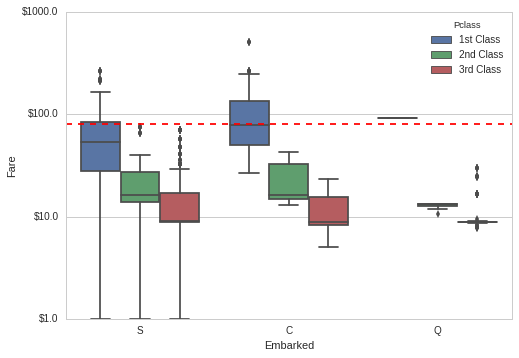

In [8]:
## Clean up missing variables
## Cabin - too many missing to impute with conviction so feature engineer Deck var where
## first letter of Cabin is Deck. Missing values encoded as U (for Unknown)

full['Deck'] = full.Cabin.str.extract(r'(\w)\d*')
full.Deck = np.where(full.Deck.isnull(), 'U', full.Deck)

## Embarked - Looking at the distribution of these passenger fares with respect to passenger 
## class and port of embarkation, there is a strong case to be made for 'C' (Charbourg) being 
## the missing value of our first class passengers. The median cost of a 1st class passengers
## ticket from Charbourg is around $80 - exactly the price our missing values.

df = full[full.Embarked.notnull()]
sns.set(style = 'whitegrid')
g = sns.categorical.boxplot('Embarked', df.Fare + 1,'Pclass', data = df)
g.set_yscale('log')
g.set_ylim(top = 1000)
g.set_yticklabels(['${:.1f}'.format(y) for y in g.get_yticks()])
g.axhline(y=80, ls = '--', color = 'r');

full.Embarked = np.where(~full.Embarked.notnull(),'C',full.Embarked)

In [9]:
## Fare - 1 missing value. 

full[full.Fare.isnull()]

## Third class, Male, embarked from S. Let's take a look at the distribution

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,df,Deck
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3rd Class,male,0,NaN,3701,Test,U


/home/gregory/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


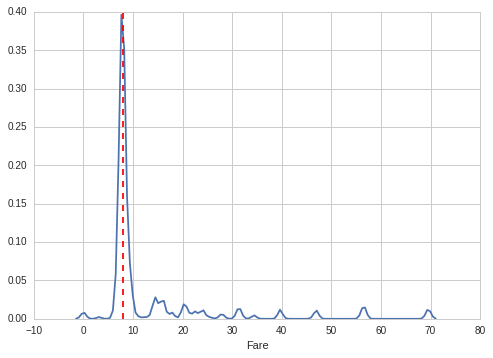

In [10]:
df_3rd_S = full[(full.Pclass == '3rd Class') & (full.Embarked == 'S') 
                   & (full.Fare.notnull()) & (full.Sex == 'male')]
sns.distplot(df_3rd_S.Fare.dropna(), hist = False)
plt.axvline(x = df_3rd_S.Fare.median(), ls = '--', color = 'r');

In [11]:
## Reasonable to assume that we can use the median fare from distribution plot.

full.loc[full.Fare.isnull(), 'Fare'] = df_3rd_S.Fare.median()

In [12]:
## Age - First we are going to create new variable Title which will both help in imputing
## age and an interesting variable for survival prediction.

salutations = full.Name.str.extract(r'\s(\w*)\.', flags= re.IGNORECASE)
salutations.value_counts()

/home/gregory/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Ms            2
Mlle          2
Capt          1
Mme           1
Dona          1
Don           1
Sir           1
Countess      1
Lady          1
Jonkheer      1
Name: Name, dtype: int64

In [13]:
## Can group similar titles together to decrease number of categories.
salutations[salutations.isin(['Ms', 'Mlle'])] = 'Miss'
salutations[salutations.isin(['Don', 'Jonkheer'])] = 'Sir'
salutations[salutations.isin(['Dona', 'Lady', 'Countess'])] = 'Lady'
salutations[salutations.isin(['Mme'])] = 'Mrs'
salutations[salutations.isin(['Capt', 'Major', 'Col'])] = 'Officer'
full['Title'] = salutations

full.Title.value_counts()

Mr         757
Miss       264
Mrs        198
Master      61
Rev          8
Dr           8
Officer      7
Sir          3
Lady         3
Name: Title, dtype: int64

In [14]:
pd.crosstab(full.Title, full.Survived, margins=True)

Survived,0.0,1.0,All
Title,,,
Dr,4,3,7
Lady,0,2,2
Master,17,23,40
Miss,55,130,185
Mr,436,81,517
Mrs,26,100,126
Officer,3,2,5
Rev,6,0,6
Sir,2,1,3


In [15]:
## To impute the missing values of Age, will group data set by both Title and Pclass and for
## each group, use the median value. Note - maybe try predictive imputation of Age

full['Age_Med_Imp'] = full.Age
fill_median = lambda g: g.fillna(g.median())
full.Age_Med_Imp = full.groupby(['Title', 'Pclass'])['Age_Med_Imp'].apply(fill_median)

In [16]:
## Feature Engineering

In [17]:
## Create a variable Family_Size
def family_size(row):
    return row['SibSp'] + row['Parch'] + 1

full['Family_Size'] = full.apply(family_size, axis= 1)

In [18]:
## create variable person_type (child, adult_male, adult_female) - will use 14 as the age defining a child

In [19]:
def person_type(row):
    if row['Age_Med_Imp'] <= 14:
        return 'child'
    elif row['Sex'] == 'male':
        return 'adult_male'
    else:
        return 'adult_female'
    
full['person_type'] = full.apply(person_type, axis = 1)

In [20]:
## Create a family_group - concatenating Surname and family size. Not perfect but hopefully we can extract some
## family surviving patterns

full['family_group'] = full.Name.str.extract(r'([\w\s]+),', re.IGNORECASE)

/home/gregory/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [21]:
## Create a ticket dictionary that can be used to map key ticket info back to dataframe

In [22]:
Ticket_dict = {}
for index, row in full.iterrows():
    Ticket_dict[row['Ticket']] = Ticket_dict.get(row['Ticket'],{'Passenger_count':0, 'Passenger_Surnames': set([]), 'Unique_Surnames': 0})
    
    Ticket_dict[row['Ticket']]['Passenger_count'] += 1
    Ticket_dict[row['Ticket']]['Passenger_Surnames'].add(row['family_group'])
    Ticket_dict[row['Ticket']]['Unique_Surnames'] = len(Ticket_dict[row['Ticket']]['Passenger_Surnames'])


Ticket_map = pd.DataFrame.from_dict(Ticket_dict,orient='index')



In [23]:
def ticket_type(row):
    if row['Passenger_count'] == 1:
        return 'individual'
    elif (row['Passenger_count'] > 1)&(row['Unique_Surnames'] == 1):
        return 'family'
    elif (row['Passenger_count'] > 1)&(row['Unique_Surnames'] == row['Passenger_count']):
        return 'friends'
    else:
        return 'family/friends'

In [24]:
Ticket_map['ticket_type'] = Ticket_map.apply(ticket_type, axis = 1)
Ticket_map.ticket_type.value_counts()

individual        713
family            149
friends            40
family/friends     27
Name: ticket_type, dtype: int64

In [25]:
Ticket_map.head()

,Passenger_Surnames,Unique_Surnames,Passenger_count,ticket_type
110152,"{Rothes, Cherry, Maioni}",3,3,friends
110413,{Taussig},1,3,family
110465,"{Clifford, Porter}",2,2,friends
110469,{Maguire},1,1,individual
110489,{Borebank},1,1,individual


In [26]:
## Add ticket_type and passengers_on_ticket variables to main dataframe

In [27]:
full['ticket_type'] = full.Ticket.map(Ticket_map.ticket_type)
full['passengers_on_ticket'] = full.Ticket.map(Ticket_map.Passenger_count)

In [28]:
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket,df,Deck,Title,Age_Med_Imp,Family_Size,person_type,family_group,ticket_type,passengers_on_ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3rd Class,male,1,...,A/5 21171,Train,U,Mr,22.0,2,adult_male,Braund,individual,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1st Class,female,1,...,PC 17599,Train,C,Mrs,38.0,2,adult_female,Cumings,family,2
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3rd Class,female,0,...,STON/O2. 3101282,Train,U,Miss,26.0,1,adult_female,Heikkinen,individual,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1st Class,female,1,...,113803,Train,C,Mrs,35.0,2,adult_female,Futrelle,family,2
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3rd Class,male,0,...,373450,Train,U,Mr,35.0,1,adult_male,Allen,individual,1


In [29]:
full['Singleton'] = np.where((full.Family_Size == 1)&(full.passengers_on_ticket == 1), 1, 0)

In [30]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [31]:
print_full(full[['family_group', 'Family_Size', 'ticket_type', 'passengers_on_ticket', 
                 'Ticket']][(full.ticket_type == 'friends')&(full.Family_Size>1)].sort_values(['Ticket','family_group']))

     family_group  Family_Size ticket_type  passengers_on_ticket    Ticket
356      Bowerman            2     friends                     2    113505
166      Chibnall            2     friends                     2    113505
1041     Earnshaw            2     friends                     3     11767
879        Potter            2     friends                     3     11767
571      Appleton            3     friends                     2     11769
1247        Brown            3     friends                     2     11769
925          Mock            2     friends                     2     13236
1013     Schabert            2     friends                     2     13236
275       Andrews            2     friends                     3     13502
765      Hogeboom            2     friends                     3     13502
259       Parrish            2     friends                     2    230433
880       Shelley            2     friends                     2    230433
689        Madill        

In [32]:
full[full.family_group.str.contains('Andersson')]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,df,Deck,Title,Age_Med_Imp,Family_Size,person_type,family_group,ticket_type,passengers_on_ticket,Singleton
13,39.0,NaN,S,31.2750,"Andersson, Mr. Anders Johan",5,14,3rd Class,male,1,...,Train,U,Mr,39.0,7,adult_male,Andersson,family,7,0
68,17.0,NaN,S,7.9250,"Andersson, Miss. Erna Alexandra",2,69,3rd Class,female,4,...,Train,U,Miss,17.0,7,adult_female,Andersson,individual,1,0
119,2.0,NaN,S,31.2750,"Andersson, Miss. Ellis Anna Maria",2,120,3rd Class,female,4,...,Train,U,Miss,2.0,7,child,Andersson,family,7,0
146,27.0,NaN,S,7.7958,"Andersson, Mr. August Edvard (""Wennerstrom"")",0,147,3rd Class,male,0,...,Train,U,Mr,27.0,1,adult_male,Andersson,individual,1,1
541,9.0,NaN,S,31.2750,"Andersson, Miss. Ingeborg Constanzia",2,542,3rd Class,female,4,...,Train,U,Miss,9.0,7,child,Andersson,family,7,0
542,11.0,NaN,S,31.2750,"Andersson, Miss. Sigrid Elisabeth",2,543,3rd Class,female,4,...,Train,U,Miss,11.0,7,child,Andersson,family,7,0
610,39.0,NaN,S,31.2750,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",5,611,3rd Class,female,1,...,Train,U,Mrs,39.0,7,adult_female,Andersson,family,7,0
813,6.0,NaN,S,31.2750,"Andersson, Miss. Ebba Iris Alfrida",2,814,3rd Class,female,4,...,Train,U,Miss,6.0,7,child,Andersson,family,7,0
850,4.0,NaN,S,31.2750,"Andersson, Master. Sigvard Harald Elias",2,851,3rd Class,male,4,...,Train,U,Master,4.0,7,child,Andersson,family,7,0
1105,38.0,NaN,S,7.7750,"Andersson, Miss. Ida Augusta Margareta",2,1106,3rd Class,female,4,...,Test,U,Miss,38.0,7,adult_female,Andersson,individual,1,0


In [33]:
## create variable child_died. This will be set to 1 for passengers, who had a child die that was in their family group
## (by surname) or on their ticket.

In [34]:
dead_child = full[(full.person_type == 'child') & (full.Survived == 0) & (full.Singleton == 0)][['Name', 'Ticket', 'family_group']]
dead_child

def child_died(row):
    if row['Singleton'] == 1:
        return 0
    elif ((row['family_group'] in dead_child.family_group.values)|(row['Ticket'] in dead_child.Ticket.values)):
        return 1
    else:
        return 0

full['child_died'] = full.apply(child_died, axis= 1)

In [35]:
full.child_died.value_counts()

0    1224
1      85
Name: child_died, dtype: int64

In [36]:
perishing_female_relation = full[(full.person_type == 'adult_female') & (full.Survived == 0) & (full.Singleton == 0)][['Name', 'Ticket', 'family_group']]


def female_perished_in_group(row):
    if row['Singleton'] == 1:
        return 0
    elif ((row['family_group'] in perishing_female_relation.family_group.values)|(row['Ticket'] in perishing_female_relation.Ticket.values)):
        return 1
    else:
        return 0

full['perishing_female_in_group'] = full.apply(female_perished_in_group, axis= 1)

In [37]:
full.perishing_female_in_group.value_counts()

0    1185
1     124
Name: perishing_female_in_group, dtype: int64

In [38]:
surviving_male_relation = full[(full.person_type == 'adult_male') & (full.Survived == 1) & (full.Singleton == 0)][['Name', 'Ticket', 'family_group']]


def male_survivor_in_group(row):
    if row['Singleton'] == 1:
        return 0
    elif ((row['family_group'] in surviving_male_relation.family_group.values)|(row['Ticket'] in surviving_male_relation.Ticket.values)):
        return 1
    else:
        return 0

full['surviving_male_in_group'] = full.apply(male_survivor_in_group, axis= 1)

In [39]:
full.surviving_male_in_group.value_counts()

0    1238
1      71
Name: surviving_male_in_group, dtype: int64

In [40]:
full.columns.values

array(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'df', 'Deck',
       'Title', 'Age_Med_Imp', 'Family_Size', 'person_type',
       'family_group', 'ticket_type', 'passengers_on_ticket', 'Singleton',
       'child_died', 'perishing_female_in_group', 'surviving_male_in_group'], dtype=object)

In [41]:
full.head()[['Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck', 'Title', 
             'Age_Med_Imp', 'Family_Size', 'person_type', 'family_group', 'ticket_type', 'passengers_on_ticket',
             'Singleton', 'child_died', 'perishing_female_in_group', 'surviving_male_in_group']]

,Embarked,Fare,Parch,Pclass,Sex,SibSp,Deck,Title,Age_Med_Imp,Family_Size,person_type,family_group,ticket_type,passengers_on_ticket,Singleton,child_died,perishing_female_in_group,surviving_male_in_group
0,S,7.2500,0,3rd Class,male,1,U,Mr,22.0,2,adult_male,Braund,individual,1,0,0,0,0
1,C,71.2833,0,1st Class,female,1,C,Mrs,38.0,2,adult_female,Cumings,family,2,0,0,0,0
2,S,7.9250,0,3rd Class,female,0,U,Miss,26.0,1,adult_female,Heikkinen,individual,1,1,0,0,0
3,S,53.1000,0,1st Class,female,1,C,Mrs,35.0,2,adult_female,Futrelle,family,2,0,0,0,0
4,S,8.0500,0,3rd Class,male,0,U,Mr,35.0,1,adult_male,Allen,individual,1,1,0,0,0


In [42]:
df = full.copy()

In [43]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [44]:
df.loc[:,'Embarked'] = label_encoder.fit_transform(df.Embarked)
df.loc[:,'Pclass'] = label_encoder.fit_transform(df.Pclass)
df.loc[:,'Sex'] = label_encoder.fit_transform(df.Sex)
df.loc[:,'Deck'] = label_encoder.fit_transform(df.Deck)
df.loc[:,'Title'] = label_encoder.fit_transform(df.Title)
df.loc[:,'person_type'] = label_encoder.fit_transform(df.person_type)
df.loc[:,'family_group'] = label_encoder.fit_transform(df.family_group)
df.loc[:,'ticket_type'] = label_encoder.fit_transform(df.ticket_type)

In [45]:
df.loc[df['Singleton'] == 1,'family_group'] = -1

In [46]:
## Split back to train/test

In [47]:
df_train = df[df['df'] == 'Train']
df_test = df[df['df'] == 'Test']

In [48]:
feature_vars = ['Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck', 'Title', 
             'Age_Med_Imp', 'Family_Size', 'person_type', 'family_group', 'ticket_type', 'passengers_on_ticket',
             'Singleton', 'child_died', 'perishing_female_in_group', 'surviving_male_in_group']
X_train = df_train[feature_vars]
X_test = df_test[feature_vars]
y_train = df_train.Survived

In [49]:
def cv_scorer(model, folds, X, y, scoring= 'accuracy'):
    kf = sklearn.model_selection.StratifiedKFold(folds, True)
    scores = sklearn.model_selection.cross_val_score(model, X, y, scoring= scoring, cv = kf)
    return np.mean(scores)

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [51]:
dt = DecisionTreeClassifier()
cv_scorer(dt, 10, X_train, y_train)

0.85632589944387694

In [52]:
dt = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 15, 20],
              "max_depth": [None, 2, 5, 10, 15],
              "min_samples_leaf": [1, 5, 10, 20],
              "max_leaf_nodes": [None, 5, 10, 20, 30],
              }
grid = GridSearchCV(dt, param_grid, scoring = 'accuracy', cv = 10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 5, 10, 20], 'max_leaf_nodes': [None, 5, 10, 20, 30], 'min_samples_split': [2, 10, 15, 20], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [53]:
grid.best_estimator_, grid.best_score_

(DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
             max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'), 0.8922558922558923)

In [54]:
def make_sub(filename, predicts):
    submission = pd.DataFrame({"PassengerId":df_test.PassengerId,
                           "Survived":predicts.astype(int)})
    submission.to_csv("{}.csv".format(filename),index=False) 

In [55]:
dt = DecisionTreeClassifier(**grid.best_params_)
dt.fit(X_train, y_train)
print(sklearn.metrics.accuracy_score(y_train, dt.predict(X_train)))
print(cv_scorer(dt, 10,X_train, y_train))
preds = dt.predict(X_test)

0.895622895623
0.88540205425


In [56]:
make_sub('DT_Titanic_Survival', preds)

In [57]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_

features.sort_values('importance', ascending=False)

,feature,importance
4,Sex,0.190604
8,Age_Med_Imp,0.136885
10,person_type,0.128066
1,Fare,0.116131
16,perishing_female_in_group,0.100233
17,surviving_male_in_group,0.060409
3,Pclass,0.050651
7,Title,0.040235
6,Deck,0.038171
15,child_died,0.027468


In [137]:
## Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier

In [139]:
rv = RandomForestClassifier(max_features=None)
parameter_grid = {
                 'max_depth' : [4,5,6,7,8],
                 'n_estimators': [200,210,240,250],
                 'criterion': ['gini','entropy']
                 }

cross_validation = sklearn.model_selection.StratifiedKFold(10)

grid = GridSearchCV(rv,param_grid=parameter_grid,cv=cross_validation, scoring= 'accuracy')

grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [200, 210, 240, 250], 'max_depth': [4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [140]:
print('Best score: {}'.format(grid.best_score_))
print('Best parameters: {}'.format(grid.best_params_))

Best score: 0.8956228956228957
Best parameters: {'criterion': 'gini', 'n_estimators': 210, 'max_depth': 7}


In [141]:
rv =RandomForestClassifier( **grid.best_params_)
rv.fit(X_train, y_train)
print(sklearn.metrics.accuracy_score(y_train, rv.predict(X_train)))
print(cv_scorer(rv, 10, X_train, y_train))
preds = rv.predict(X_test)

0.928170594837
0.887774656679


In [143]:
make_sub('RF_Titanic_Survival', preds)

In [147]:
model_rf = RandomForestClassifier(n_estimators=20000, min_samples_leaf=4, class_weight={0:0.62,1:0.38})

In [149]:
model_rf.fit(X_train, y_train)
model_results = model_rf.predict(X_test)

In [146]:
pd.crosstab(df_train.Survived,'count', normalize= True)

col_0,count
Survived,
0.0,0.616162
1.0,0.383838


In [150]:
make_sub('RF_2_Titanic_Survival', model_results)

In [ ]:
## svm

In [58]:
from sklearn.svm import SVC

In [ ]:
clf = SVC()
param_grid =   [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}]
grid = GridSearchCV(clf, param_grid, cv = 10)
grid.fit(X_train, y_train)

In [87]:
## from collections import Counter
## cnt = Counter()
## for ticket in full.Ticket:
##     cnt[ticket] +=1

## full['passengers_on_ticket'] = full.Ticket.map(cnt)
    

In [159]:
## from collections import Counter
## cnt = Counter()
## for surname in full.family_group:
##     cnt[surname] +=1

## full['Surname_count'] = full.family_group.map(cnt)